# Análise do Portfolio de Fundos

### Inicializações

In [41]:
import pandas as pd
import numpy as np

from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("whitegrid")


In [42]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')
exchange_rates.head()

,USD2EUR
Date,
2022-10-29,1.00350
2022-10-28,1.00350
2022-10-27,1.00290
2022-10-26,0.99208
2022-10-25,1.00420


In [43]:
#Get the Portofolio
portfolio_csv = 'portofolio.csv'
df_portofolio = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
code2name_dict = {x[0]:x[1] for x in df_portofolio.itertuples()}
df_portofolio.sort_values(by="Nome", axis=0)

,Nome,Moeda,Quantidade
Code,,,
LU0494093627,BGF ESG Mult-Asset,USD,86.9900
LU0171309270,BGF Healthscience E2 EUR,EUR,64.2900
LU0171310955,BGF Wor Techn EUR E,EUR,172.9100
LU0823417141,BNP Health Care In\tN Capit,EUR,20.4270
LU0108459040,Candriam Biotech C Cap USD,USD,7.2710
LU1769942746,DWS CROCI US Divid,USD,8.9870
LU2210151697,FF Abs Ret Gb Eq,USD,1031.2300
LU1046545411,GS N America Energy Infra USD,USD,493.9260
LU0213962813,HSBC Turkey Equity Eur,EUR,46.3050


In [44]:
#Get the historical quotes 

xls = 'historico_cotacoes.xlsx'
dict_df = pd.read_excel(xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date'], infer_datetime_format = True).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df = df_all.dropna()

#Create a DataFrame with the daily growth
df_grow = df.apply(lambda x: x/x.shift(-1), axis=0).dropna()

df_all.head()

,IE00BLP5S353,LU0121204431,LU0122613903,LU0171310955,LU0094557526,LU0171309270,LU0244354824,LU0248173006,PTSQUGHM0007,LU0384381660,LU0494093627,LU0823417141,LU1769942746,LU2210151697,IE00BD3B6K23,LU0108459040,LU1670715975,LU0213962813,LU1176912761,LU1046545411
Date,,,,,,,,,,,,,,,,,,,,
2022-10-28,1.35,478.37,NaN,NaN,42.26,NaN,269.55,34.55,NaN,60.26,42.76,NaN,308.82,10.61,NaN,NaN,37.97,31.50,115.20,9.65
2022-10-27,1.36,468.20,NaN,NaN,41.91,NaN,280.41,35.20,NaN,60.43,42.71,405.71,307.80,10.53,109.40,727.84,37.81,32.18,115.41,9.61
2022-10-26,1.36,468.65,NaN,NaN,41.82,NaN,277.24,34.89,NaN,59.54,42.66,408.26,304.03,10.45,109.39,739.00,37.94,32.74,114.67,9.44
2022-10-25,1.36,473.83,NaN,NaN,41.71,NaN,270.56,34.63,NaN,58.80,42.67,405.70,303.16,10.50,109.40,731.73,37.74,33.11,114.97,9.37
2022-10-24,1.37,467.56,NaN,NaN,41.04,NaN,273.65,35.11,NaN,58.62,42.36,400.94,302.32,10.51,109.38,720.12,37.49,33.41,116.39,9.44


In [45]:
# Calculate the Portofolio Std and Growth
df_portofolio['STD'] = df_grow.std(axis=0)
df_portofolio['Growth'] = df.apply(lambda x: x[0]/x[-1]-1)
df_portofolio['Racio'] = df_portofolio['Growth']/df_portofolio['STD']

In [46]:
# Get the Current Total Amount in EUR

last_date = min(df_all.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date][0]
# Get the last Quotes
quotes = df_all.fillna(method='bfill').iloc[0]

df_portofolio['Amount EUR'] = df_portofolio['Moeda'].apply(lambda x: usd2eur if x == 'USD' else 1) * quotes * df_portofolio['Quantidade']

sum(df_portofolio['Amount EUR'])

118869.874937585

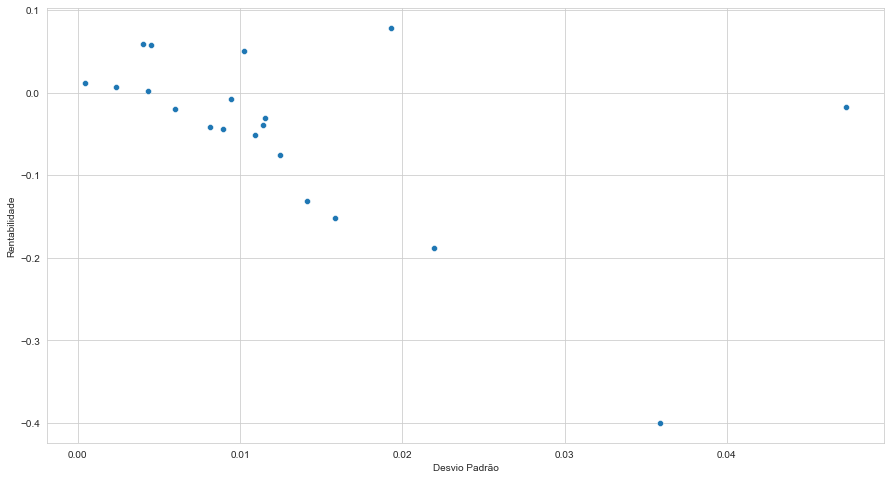

In [47]:
plt.figure(figsize=(15,8))
plt.xlabel('Desvio Padrão')
plt.ylabel('Rentabilidade')
p = sn.scatterplot(x=df_portofolio['STD'],y=df_portofolio['Growth'])

In [48]:
df_portofolio.sort_values(by=['Nome'],ascending=True)

,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
LU0494093627,BGF ESG Mult-Asset,USD,86.9900,0.005983,-0.019813,-3.311614,3732.711323
LU0171309270,BGF Healthscience E2 EUR,EUR,64.2900,0.009437,-0.008330,-0.882723,3424.728300
LU0171310955,BGF Wor Techn EUR E,EUR,172.9100,0.021922,-0.187803,-8.566973,7777.491800
LU0823417141,BNP Health Care In\tN Capit,EUR,20.4270,0.011524,-0.030531,-2.649294,8287.438170
LU0108459040,Candriam Biotech C Cap USD,USD,7.2710,0.014155,-0.131506,-9.290167,5310.647076
LU1769942746,DWS CROCI US Divid,USD,8.9870,0.010225,0.049739,4.864475,2785.079119
LU2210151697,FF Abs Ret Gb Eq,USD,1031.2300,0.004328,0.002012,0.464852,10979.645026
LU1046545411,GS N America Energy Infra USD,USD,493.9260,0.019317,0.078484,4.062894,4783.068251
LU0213962813,HSBC Turkey Equity Eur,EUR,46.3050,0.047344,-0.017888,-0.377833,1458.607500


c:\MyPrograms\miniconda3\envs\fundos\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\MyPrograms\miniconda3\envs\fundos\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 1080x576 with 0 Axes>

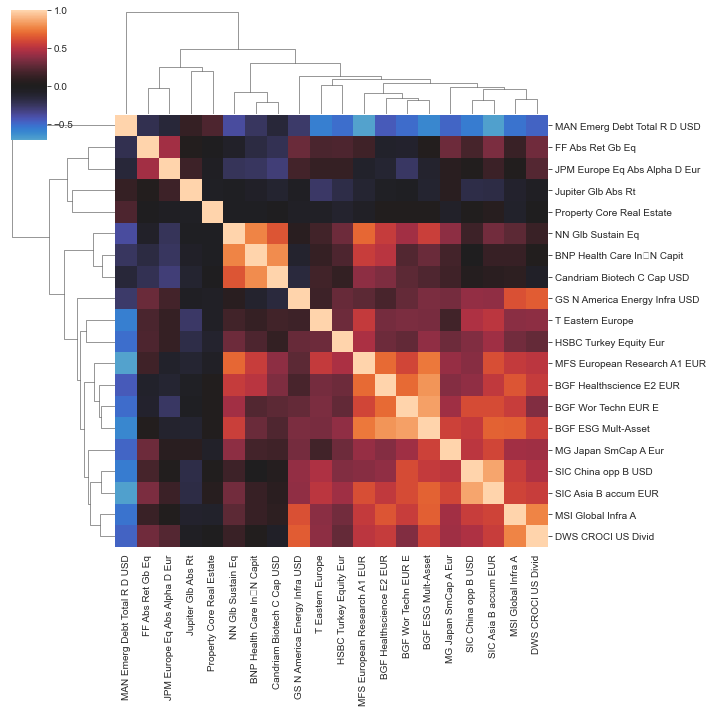

In [49]:
plt.figure(figsize=(15,8))
sn.clustermap(df_grow.rename(columns=code2name_dict).corr(),center=0)
#df_grow.corr()

In [50]:
##### Performance in the last days
df_portofolio_tmp = df_portofolio.copy()
start =20
finish = 0
print('Start Date:',df_all.index[start])
df_portofolio_tmp['Growth'] = df_all.fillna(method='bfill').fillna(method='pad').apply(lambda x: x[finish]/x[start]-1)
df_portofolio_tmp['Racio'] = df_portofolio_tmp['Growth']/df_portofolio_tmp['STD']
df_portofolio_tmp.sort_values(by=['Racio'],ascending=False)

Start Date: 2022-09-30


,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
LU1769942746,DWS CROCI US Divid,USD,8.9870,0.010225,0.097363,9.522187,2785.079119
LU1046545411,GS N America Energy Infra USD,USD,493.9260,0.019317,0.162651,8.419913,4783.068251
LU0094557526,MFS European Research A1 EUR,EUR,85.0860,0.008149,0.065826,8.077403,3595.734360
PTSQUGHM0007,Property Core Real Estate,EUR,2621.3242,0.000452,0.001873,4.143278,28048.168940
LU0121204431,NN Glb Sustain Eq,EUR,7.1900,0.012457,0.049011,3.934260,3439.480300
LU0213962813,HSBC Turkey Equity Eur,EUR,46.3050,0.047344,0.162362,3.429415,1458.607500
LU0108459040,Candriam Biotech C Cap USD,USD,7.2710,0.014155,0.035364,2.498254,5310.647076
LU2210151697,FF Abs Ret Gb Eq,USD,1031.2300,0.004328,0.009515,2.198207,10979.645026
LU0823417141,BNP Health Care In\tN Capit,EUR,20.4270,0.011524,0.018937,1.643207,8287.438170


Start Date: 2022-09-30


<AxesSubplot:xlabel='Date'>

c:\MyPrograms\miniconda3\envs\fundos\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\MyPrograms\miniconda3\envs\fundos\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


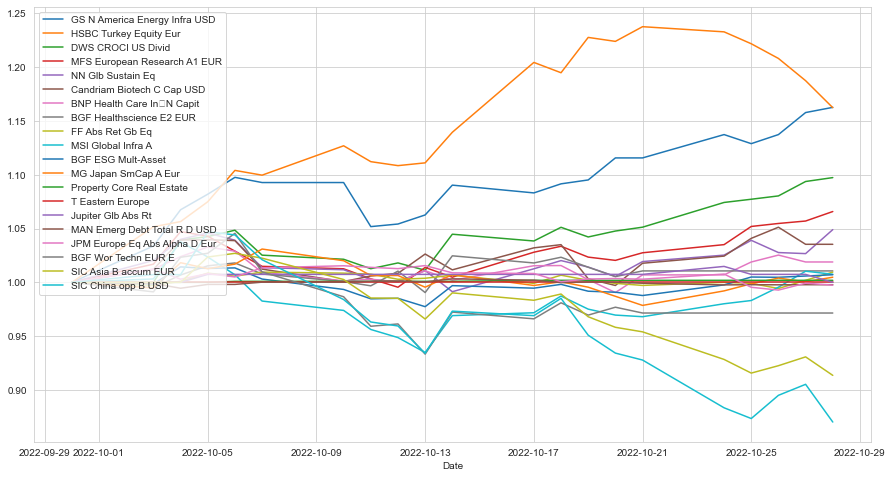

In [51]:
print('Start Date:',df_all.index[start])
df_all_tmp = df_all.fillna(method='bfill').fillna(method='pad').apply(lambda x: x/x[start], axis=0)
df_all_tmp = df_all_tmp.sort_values(by=df_all_tmp.index[finish],axis=1,ascending=False).rename(columns=code2name_dict)
ax = df_all_tmp.iloc[finish:start+1].plot(figsize=(15,8),grid=True)
ax.legend(loc='upper left')
ax

In [57]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

if 'LU0122613903' in dict_df:
    del dict_df['LU0122613903']

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df = df_all #.dropna()

# print(df.index)

mu = mean_historical_return(df.sort_index())
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
df_mu = pd.DataFrame(data = {'Name':df_portofolio['Nome'],'all':list(mu)}, index=list(mu.keys()))
df_w = pd.DataFrame(data = {'Name':df_portofolio['Nome'] ,'all':list(cleaned_weights.values())}, index=list(cleaned_weights.keys()))
df_pp = pd.DataFrame(data = {'all':list(ef.portfolio_performance())}, index=list(['anual return','volatility','sharpe ratio']))
mu_coef = {'all':0.3,90:0.3,5:0.15,10:0.15,30:0.10}
mu_w = mu_coef['all']*mu
for n in mu_coef.keys()-['all']:
    mu = mean_historical_return(df[:n].sort_index())
    
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    if n == 60:
        mu_w += 0.30*mu
    else:
        mu_w += 0.175*mu
    df_mu[n] = list(mu)
    df_w[n] = list(cleaned_weights.values())
    df_pp[n] = list(ef.portfolio_performance())
    

ef = EfficientFrontier(mu_w, S)
weights = ef.max_sharpe()

df_w['Avg'] = list(ef.clean_weights().values())
df_w['Now'] = df_portofolio_tmp['Amount EUR']/df_portofolio_tmp['Amount EUR'].sum()
df_pp['Avg'] = list(ef.portfolio_performance())
df_mu['Avg'] = list(mu_w)
df_mu.sort_values(by="Avg",ascending=False)

,Name,all,5,10,90,30,Avg
LU1046545411,GS N America Energy Infra USD,0.282795,2.999310,6.269314,0.501273,0.891945,1.950661
LU1769942746,DWS CROCI US Divid,0.030198,2.819689,3.688579,0.023282,0.485712,1.237080
LU0094557526,MFS European Research A1 EUR,-0.062416,5.331329,1.750863,-0.002007,0.004122,1.221029
LU0384381660,MSI Global Infra A,-0.107966,4.687858,1.752318,-0.258392,-0.585097,0.947030
LU0213962813,HSBC Turkey Equity Eur,0.614236,-0.975490,-0.630435,2.212335,3.594816,0.919485
LU0121204431,NN Glb Sustain Eq,0.052410,3.220607,1.689884,0.027921,-0.096837,0.862999
LU2210151697,FF Abs Ret Gb Eq,0.063112,0.815926,0.338845,0.118050,0.170021,0.271431
LU0823417141,BNP Health Care In\tN Capit,0.056425,1.106631,0.100864,0.125160,-0.035066,0.244006
LU1670715975,MG Japan SmCap A Eur,-0.086472,1.228871,0.239458,0.102818,-0.123455,0.227404
LU0108459040,Candriam Biotech C Cap USD,-0.101140,0.957744,0.093510,0.159385,0.079379,0.195411


In [58]:
df[:5].sort_index()

,IE00BLP5S353,LU0121204431,LU0171310955,LU0094557526,LU0171309270,LU0244354824,LU0248173006,PTSQUGHM0007,LU0384381660,LU0494093627,LU0823417141,LU1769942746,LU2210151697,IE00BD3B6K23,LU0108459040,LU1670715975,LU0213962813,LU1176912761,LU1046545411
Date,,,,,,,,,,,,,,,,,,,
2022-10-24,1.37,467.56,NaN,41.04,NaN,273.65,35.11,NaN,58.62,42.36,400.94,302.32,10.51,109.38,720.12,37.49,33.41,116.39,9.44
2022-10-25,1.36,473.83,NaN,41.71,NaN,270.56,34.63,NaN,58.80,42.67,405.70,303.16,10.50,109.40,731.73,37.74,33.11,114.97,9.37
2022-10-26,1.36,468.65,NaN,41.82,NaN,277.24,34.89,NaN,59.54,42.66,408.26,304.03,10.45,109.39,739.00,37.94,32.74,114.67,9.44
2022-10-27,1.36,468.20,NaN,41.91,NaN,280.41,35.20,NaN,60.43,42.71,405.71,307.80,10.53,109.40,727.84,37.81,32.18,115.41,9.61
2022-10-28,1.35,478.37,NaN,42.26,NaN,269.55,34.55,NaN,60.26,42.76,NaN,308.82,10.61,NaN,NaN,37.97,31.50,115.20,9.65


In [59]:
df_w.sort_values(by='Avg',ascending=False)

,Name,all,5,10,90,30,Avg,Now
IE00BD3B6K23,MAN Emerg Debt Total R D USD,0.20300,0.42106,0.41258,0.28387,0.43326,0.41763,0.126511
LU0094557526,MFS European Research A1 EUR,0.00000,0.26557,0.10750,0.00000,0.00000,0.23784,0.030249
LU2210151697,FF Abs Ret Gb Eq,0.09157,0.14184,0.00000,0.14693,0.15065,0.15257,0.092367
LU1769942746,DWS CROCI US Divid,0.00000,0.00000,0.24674,0.00000,0.02788,0.09711,0.023430
LU1046545411,GS N America Energy Infra USD,0.04957,0.00000,0.19712,0.02477,0.03325,0.08233,0.040238
PTSQUGHM0007,Property Core Real Estate,0.19287,0.00000,0.00000,0.16240,0.03846,0.01252,0.235957
LU1176912761,JPM Europe Eq Abs Alpha D Eur,0.19665,0.00000,0.00000,0.07066,0.00000,0.00000,0.024581
LU0213962813,HSBC Turkey Equity Eur,0.08154,0.00000,0.00000,0.15732,0.17674,0.00000,0.012271
LU1670715975,MG Japan SmCap A Eur,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.008224
LU0108459040,Candriam Biotech C Cap USD,0.00000,0.00000,0.00000,0.04003,0.02314,0.00000,0.044676


In [60]:
df_pp

,all,5,10,90,30,Avg
anual return,0.121285,2.340554,2.349342,0.421744,0.762544,0.618137
volatility,0.036935,0.044427,0.071384,0.051698,0.058167,0.044564
sharpe ratio,2.742267,52.233229,32.631227,7.771017,12.765761,13.421975


In [61]:
df_portofolio_tmp['Amount EUR']/df_portofolio_tmp['Amount EUR'].sum()

Code
IE00BD3B6K23    0.126511
IE00BLP5S353    0.099280
LU0094557526    0.030249
LU0108459040    0.044676
LU0121204431    0.028935
LU0122613903    0.005043
LU0171309270    0.028811
LU0171310955    0.065429
LU0213962813    0.012271
LU0244354824    0.017977
LU0248173006    0.006615
LU0384381660    0.008286
LU0494093627    0.031402
LU0823417141    0.069719
LU1046545411    0.040238
LU1176912761    0.024581
LU1670715975    0.008224
LU1769942746    0.023430
LU2210151697    0.092367
PTSQUGHM0007    0.235957
Name: Amount EUR, dtype: float64